Heavy lift from https://botorch.org/tutorials/closed_loop_botorch_only

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from typing import Optional

import torch

from botorch.models.transforms.input import Normalize
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.objective import GenericMCObjective
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from sklearn.manifold import TSNE

from gpytorch.kernels import MaternKernel

import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.acquisition import (
    qLogExpectedImprovement,
    qLogNoisyExpectedImprovement,
    qUpperConfidenceBound
)
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler

import json
import pandas as pd

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

import matplotlib.pyplot as plt

import sys
sys.path.append('/home/bgpelkie/Code/silica-np-synthesis/')
from sample_utilities import samples
import numpy as np

## Load existing data

In [3]:
with open('constants_2024_11_14.json', 'rt') as f:
    synth_constants = json.load(f) 

In [4]:
bounds = {}
for reactant, consts in synth_constants.items():
    bound = (consts['minimum_volume_fraction'], consts['maximum_volume_fraction'])
    bounds[reactant] = bound

In [5]:
synth_data = pd.read_csv('synth_table_ap_distance_11_14_24.csv')
synth_data = synth_data[~synth_data['ap_distance'].isna()]
#synth_data = synth_data[synth_data['ap_distance'] < 8]

In [6]:
synth_data

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,ethanol_dilute_vol,sample_dilute_vol,dilute_well,target_volume,teos_vol_frac,ammonia_vol_frac,water_vol_frac,ethanol_vol_frac,ap_distance,experiment_status,rank
2,130093e4-2947-4d37-b73a-ed4c23442ab8,20.000000,64.000000,49.000000,1567.000000,0.903794,3.190814,0.003982,NaN,NaN,NaN,1700.0,0.011765,0.037647,0.028824,0.921765,0.904308,complete,6.0
3,a3f7d49b-cc77-4468-aae0-ad451027ddc0,181.000000,9.000000,228.000000,1283.000000,0.100743,28.625618,0.034357,NaN,NaN,NaN,1701.0,0.106408,0.005291,0.134039,0.754262,1.467659,complete,38.0
4,f69628da-ff56-4f3a-ba2e-816036b87557,100.000000,52.000000,15.000000,1534.000000,0.182971,15.761151,0.019630,NaN,NaN,NaN,1701.0,0.058789,0.030570,0.008818,0.901822,1.498439,complete,58.0
5,eb5c038c-56ff-4457-93db-9b9702e3ff43,211.000000,12.000000,61.000000,1415.000000,0.086378,33.386217,0.040940,NaN,NaN,NaN,1699.0,0.124191,0.007063,0.035903,0.832843,1.627393,complete,86.0
6,56898b1b-5aed-4595-ade6-5b73d45a7808,101.000000,100.000000,33.000000,1467.000000,0.180763,15.953695,0.019736,NaN,NaN,NaN,1701.0,0.059377,0.058789,0.019400,0.862434,1.708555,complete,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,d298bae0-5f86-4a29-b399-111644195748,19.379999,28.135001,45.475003,1607.009996,1.958020,3.068406,0.003843,0.0,1700.0,E5,1700.0,0.011400,0.016550,0.026750,0.945300,1.566220,complete,78.0
174,c1a8b4e0-1bd4-4ea2-9cb4-f3a5e09fb320,31.735023,13.527698,16.593190,1638.144088,1.195727,5.024558,0.006321,0.0,1700.0,E6,1700.0,0.018668,0.007957,0.009761,0.963614,11.524239,complete,123.0
175,21d4f4ac-db02-41f9-b1ad-00c2e61fc894,52.700002,28.135001,45.475003,1573.689993,0.720046,8.343911,0.010415,476.0,1224.0,E8,1700.0,0.031000,0.016550,0.026750,0.925700,1.108877,complete,9.0
177,1e26acd9-0b68-4941-96c0-f56653643d27,23.959985,21.881726,28.995437,1625.162853,1.583742,3.793548,0.004764,0.0,1700.0,F2,1700.0,0.014094,0.012872,0.017056,0.955978,1.947684,complete,111.0


In [7]:
x_data = synth_data[['teos_vol_frac', 'ammonia_vol_frac', 'water_vol_frac']]
y_data = - synth_data['ap_distance']

In [8]:
y_data.min()

np.float64(-13.613402761084044)

In [9]:
y_data = np.exp(y_data)

## data pre-processing

In [10]:
y_data_norm = normalize(torch.tensor(y_data.to_numpy()), torch.tensor([[y_data.min()], [y_data.max()]])).reshape(-1,1)

In [11]:
bounds_torch_norm = torch.tensor([bounds['TEOS'], bounds['ammonia'], bounds['water']]).transpose(-1, -2)

In [12]:
bounds_torch_opt = torch.tensor([[0, 0, 0], [1.0, 1.0, 1.0]], dtype = torch.float32)

In [13]:
x_data_torch = torch.tensor(x_data.to_numpy())

In [14]:
x_data_norm = normalize(x_data_torch, bounds_torch_norm)

## Visualize design space

In [15]:
## Concentrations

In [16]:
x_data_norm[:,0]

tensor([0.0126, 0.6886, 0.3485, 0.8156, 0.3527, 0.0252, 0.0924, 0.2185, 0.0085,
        0.3107, 0.2647, 0.1934, 0.2605, 0.0671, 0.0631, 0.3235, 0.0755, 0.8650,
        0.5588, 0.7012, 0.5672, 0.1931, 0.4199, 0.2815, 0.3866, 0.8571, 0.3025,
        0.0967, 0.1681, 0.5081, 0.7857, 0.6727, 0.2145, 0.0168, 0.9922, 0.4916,
        0.4622, 0.0268, 0.0906, 0.3819, 0.5301, 0.5436, 0.7905, 0.2192, 0.0098,
        0.2776, 0.3102, 0.8948, 0.2654, 0.9302, 0.3518, 0.1946, 0.2612, 0.8276,
        0.5002, 0.8008, 0.0658, 0.0626, 0.2573, 0.3234, 0.0748, 0.8635, 0.7082,
        0.5590, 0.7006, 0.2155, 0.5675, 0.6177, 0.5117, 0.2644, 0.9307, 0.1939,
        0.6996, 0.9120, 0.6091, 0.1396, 0.6299, 0.2793, 0.7287, 0.2446, 0.0132,
        0.6882, 0.9679, 0.3468, 0.5227, 0.9234, 0.8227, 0.2609, 0.8146, 0.3519,
        0.7756, 0.8993, 0.3207, 0.6588, 0.8740, 0.5825, 0.0233, 0.4721, 0.6363,
        0.4454, 0.6022, 0.7287, 0.1260, 0.5606, 0.3105, 0.8684, 0.7658, 0.7856,
        0.2715, 0.4622, 0.3923, 0.3009, 

In [17]:
best_10_ind = torch.argsort(y_data_norm, dim = 0, descending = True)[0:10].reshape(-1)

In [18]:
best_10_ind

tensor([  9,   8,  27,  80,  33,   0,  18, 102, 151,  16])

In [19]:
X_best10 = x_data_norm[best_10_ind,:]

In [20]:
X_best10.shape

torch.Size([10, 3])

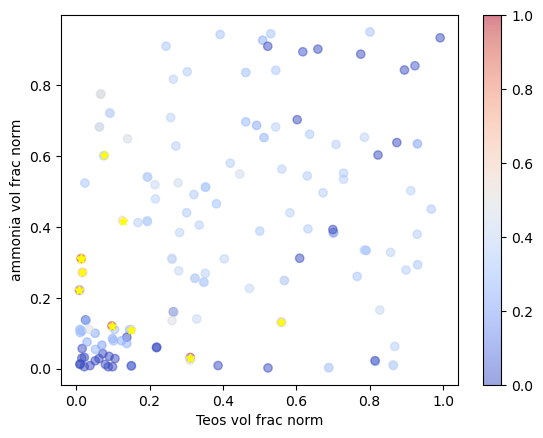

In [21]:
fig, ax = plt.subplots()

sc = ax.scatter(x_data_norm[:,0], x_data_norm[:,1], c = y_data_norm, cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac norm')
ax.set_ylabel('ammonia vol frac norm')


ax.scatter(X_best10[:,0], X_best10[:,1], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

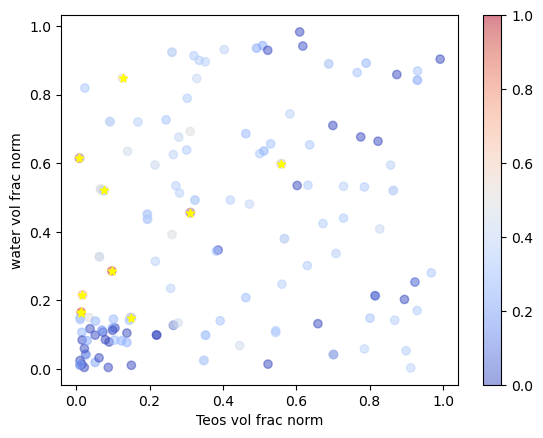

In [22]:
fig, ax = plt.subplots()

sc = ax.scatter(x_data_norm[:,0], x_data_norm[:,2], c = y_data_norm, cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac norm')
ax.set_ylabel('water vol frac norm')


ax.scatter(X_best10[:,0], X_best10[:,2], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

In [23]:
### TSNE rep

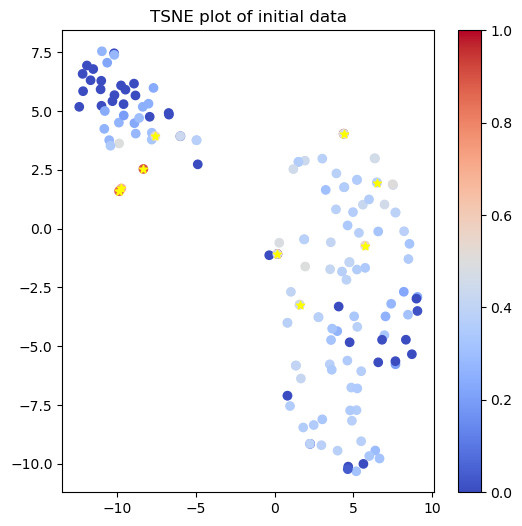

In [24]:

tsne = TSNE()

x_tsne_og = tsne.fit_transform(x_data_norm)

x_tsne_bestn = x_tsne_og[best_10_ind,:]

fig, ax = plt.subplots(figsize = (6,6))

sc = ax.scatter(x_tsne_og[:,0][:len(x_data_norm)], x_tsne_og[:,1][:len(x_data_norm)], c = y_data_norm, cmap = plt.cm.coolwarm)

ax.scatter(x_tsne_bestn[:,0], x_tsne_bestn[:,1], marker = '*', c = 'yellow')
ax.set_title("TSNE plot of initial data")
fig.colorbar(sc, ax = ax)

## Set up BO things

In [25]:
#bounds = torch.tensor([[0.0] * 3, [1.0] * 3], device=device, dtype=dtype)

BATCH_SIZE = 20  if not SMOKE_TEST else 2
NUM_RESTARTS = 50 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32

N_TRIALS = 3 if not SMOKE_TEST else 2
N_BATCH = 20 if not SMOKE_TEST else 2
MC_SAMPLES = 512 if not SMOKE_TEST else 32

## kernal parameters
nu = 5/2
ard_num_dims = 3 # None to turn off

verbose = False

train_x = x_data_norm
train_y = y_data_norm

In [26]:
def initialize_model(train_x, train_y, state_dict=None, nu = 5/2, ard_num_dims = None):
    # define models for objective and constraint
    kernel = MaternKernel(nu = nu, ard_num_dims = 3)
    model_obj = SingleTaskGP(
        train_x,
        train_y,
        input_transform=Normalize(d=train_x.shape[-1]),
        covar_module=kernel
    ).to(train_x)

    # combine into a multi-output GP model
    mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
    # load state dict if it is passed
    if state_dict is not None:
        model_obj.load_state_dict(state_dict)
    return mll, model_obj

In [27]:
def obj_callable(Z: torch.Tensor, X: Optional[torch.Tensor] = None):
    return Z[..., 0]



objective = GenericMCObjective(objective=obj_callable)

In [28]:
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)




best_observed_all_ei, best_observed_all_nei, best_random_all = [], [], []

# average over multiple trials


best_observed_ei, best_observed_nei, best_random = [], [], []

# call helper functions to generate initial training data and initialize model

mll_nei, model_nei = initialize_model(train_x, train_y)

t0 = time.monotonic()

# fit the models

fit_gpytorch_mll(mll_nei)

# define the qEI and qNEI acquisition modules using a QMC sampler
qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

# for best_f, we use the best observed noisy values as an approximation


qLogNEI = qLogNoisyExpectedImprovement(
    model=model_nei,
    X_baseline=train_x,
    sampler=qmc_sampler,
    objective=objective,
    prune_baseline=True
)

#ucb = qUpperConfidenceBound(
#    model = model_nei, 
##    beta = 5,
#    sampler = qmc_sampler, 
#)

# optimize for new candidates
candidates, _ = optimize_acqf(
    acq_function=qLogNEI,
    bounds=bounds_torch_opt,
    q=BATCH_SIZE,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    #options={"batch_limit": 5, "maxiter": 200},
)




In [29]:
posterior = model_nei.posterior(train_x)
mean = posterior.mean.detach()

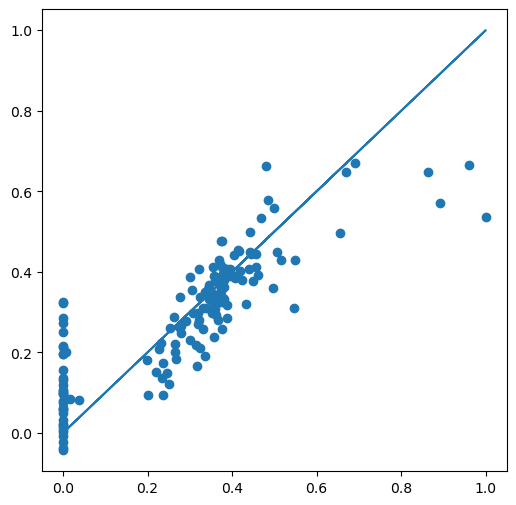

In [30]:
fig, ax = plt.subplots(figsize = (6,6))

ax.scatter(train_y, mean)
ax.plot(train_y, train_y)

(array([37.,  1., 20., 64., 21.,  4.,  3.,  0.,  2.,  2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

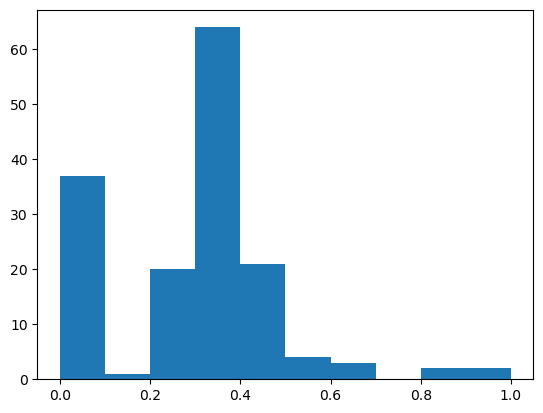

In [31]:
plt.hist(train_y)

In [32]:
train_x.max()

tensor(0.9922, dtype=torch.float64)

## Visualize model predictions

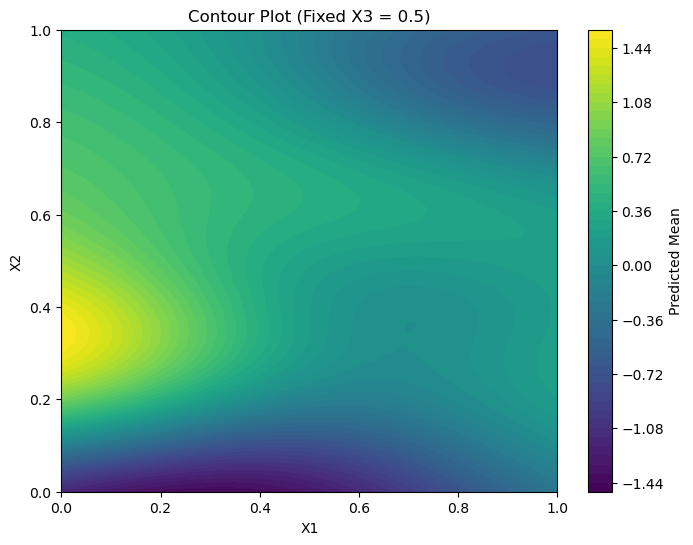

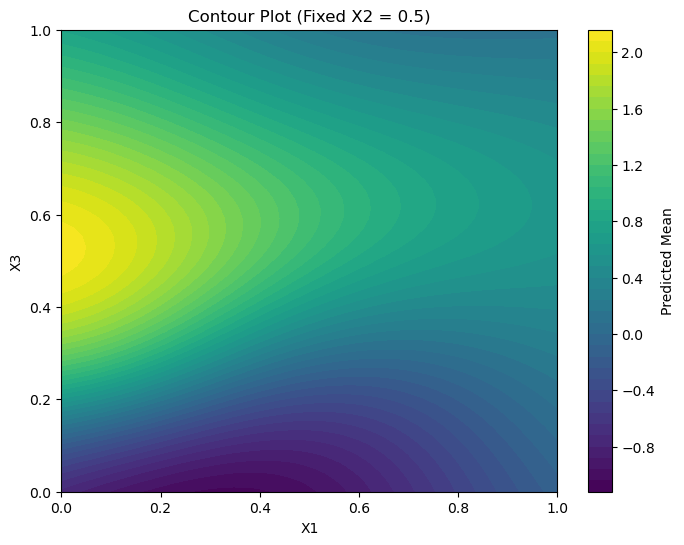

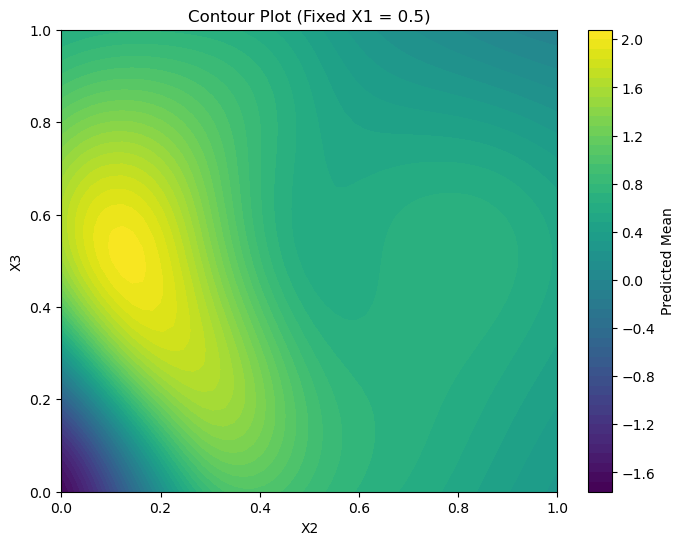

In [33]:
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots
def plot_contour_fixed_dimension(model, fixed_dim, fixed_val, x_range, y_range, dim_labels, title):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict with the model
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)
        mean = preds.mean.numpy().reshape(X.shape)  # Reshape to match grid

    # Plot the contour
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, mean, levels=50, cmap="viridis")
    plt.colorbar(cp, label="Predicted Mean")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices by fixing each dimension at a particular value
fixed_vals = [0.1, 0.1, 0.1]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=2, fixed_val=fixed_vals[2], 
                             x_range=x, y_range=y, 
                             dim_labels=["X1", "X2"], 
                             title="Contour Plot (Fixed X3 = 0.5)")


# Slice along X1 and X3, fixing X2 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=1, fixed_val=fixed_vals[1], 
                             x_range=x, y_range=z, 
                             dim_labels=["X1", "X3"], 
                             title="Contour Plot (Fixed X2 = 0.5)")

# Slice along X2 and X3, fixing X1 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=0, fixed_val=fixed_vals[0], 
                             x_range=y, y_range=z, 
                             dim_labels=["X2", "X3"], 
                             title="Contour Plot (Fixed X1 = 0.5)")


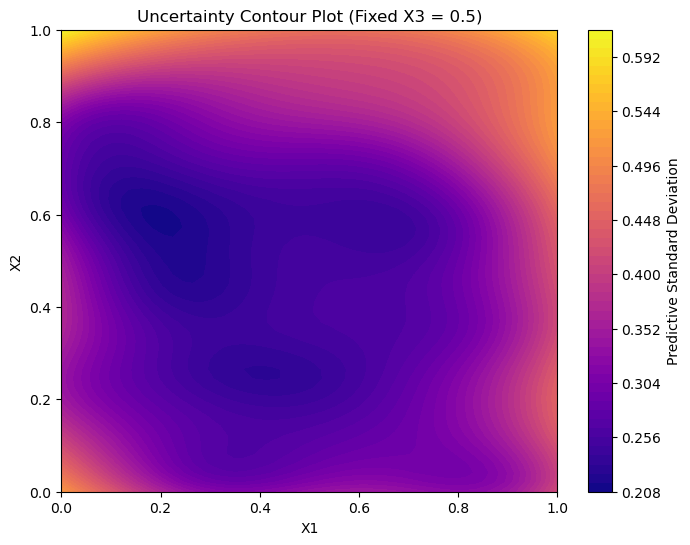

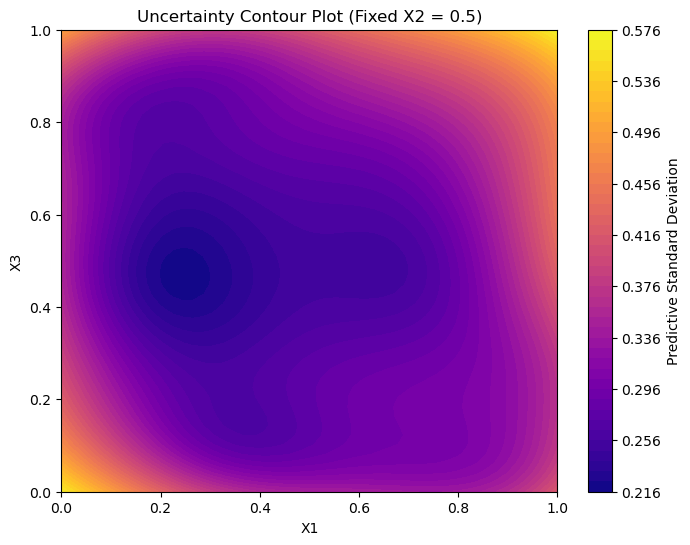

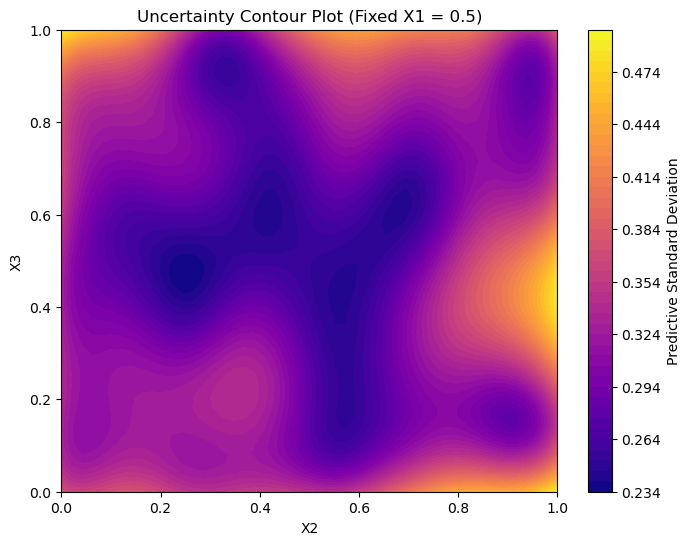

In [34]:
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots for uncertainty
def plot_contour_uncertainty(model, fixed_dim, fixed_val, x_range, y_range, dim_labels, title):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict with the model to get uncertainty (standard deviation)
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)
        std_dev = preds.variance.sqrt().numpy().reshape(X.shape)  # Reshape to match grid

    # Plot the contour of uncertainty
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, std_dev, levels=50, cmap="plasma")  # Plasma color map for uncertainty
    plt.colorbar(cp, label="Predictive Standard Deviation")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices of uncertainty by fixing each dimension at a particular value
fixed_vals = [0.5, 0.5, 0.5]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=2, fixed_val=fixed_vals[2], 
                         x_range=x, y_range=y, 
                         dim_labels=["X1", "X2"], 
                         title="Uncertainty Contour Plot (Fixed X3 = 0.5)")

# Slice along X1 and X3, fixing X2 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=1, fixed_val=fixed_vals[1], 
                         x_range=x, y_range=z, 
                         dim_labels=["X1", "X3"], 
                         title="Uncertainty Contour Plot (Fixed X2 = 0.5)")

# Slice along X2 and X3, fixing X1 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=0, fixed_val=fixed_vals[0], 
                         x_range=y, y_range=z, 
                         dim_labels=["X2", "X3"], 
                         title="Uncertainty Contour Plot (Fixed X1 = 0.5)")

## ACQ func value

In [35]:
dims = [0,1,2]
dims.remove(1)

In [36]:
dims

[0, 2]

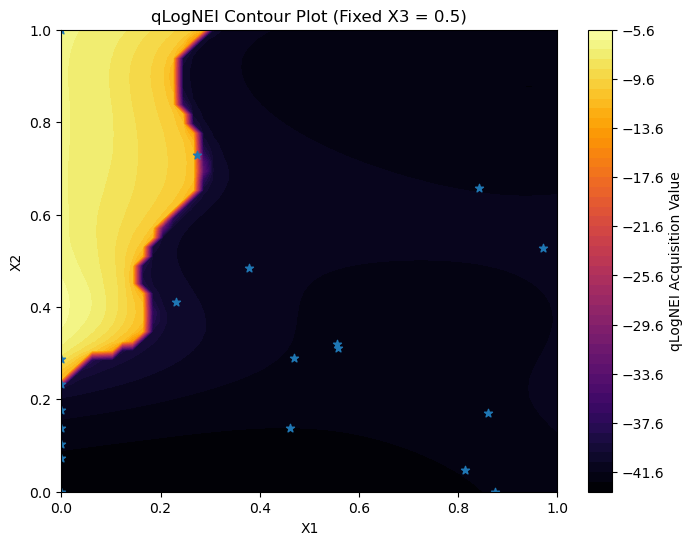

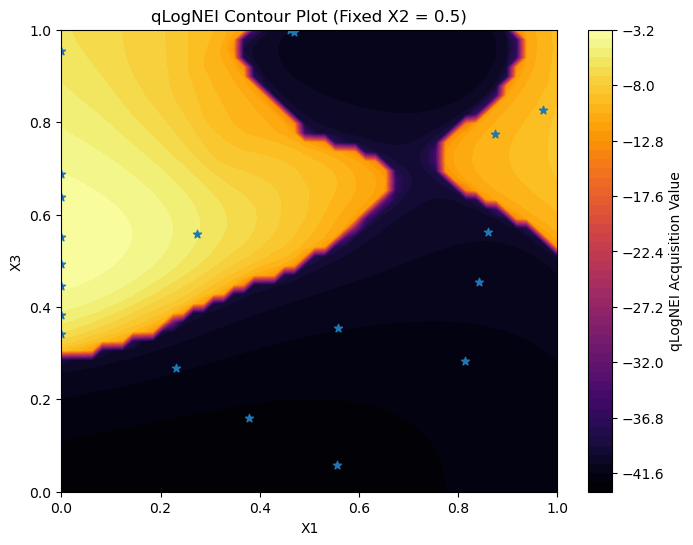

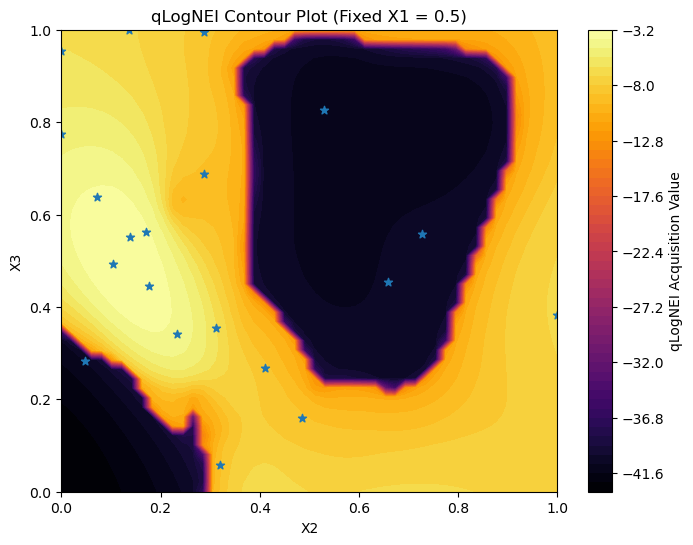

In [37]:
acq_func = qLogNEI
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots for qLogNoisyExpectedImprovement
def plot_qlognei_contour(acq_func, fixed_dim, fixed_val, x_range, y_range, dim_labels, title, candidates = candidates):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Compute qLogNoisyExpectedImprovement values at each grid point individually
    acq_func_values = []
    for i in range(grid_tensor.shape[0]):
        point = grid_tensor[i].unsqueeze(0)  # Make it a batch of 1
        acq_value = acq_func(point).item()  # Evaluate and get scalar value
        acq_func_values.append(acq_value)

    acq_func_values = np.array(acq_func_values).reshape(X.shape)  # Reshape to match grid

    dims = [0,1,2]
    dims.remove(fixed_dim)
    # Plot the contour of qLogNoisyExpectedImprovement
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, acq_func_values, levels=50, cmap="inferno")  # Inferno color map for acquisition function
    plt.scatter(candidates[:,dims[0]], candidates[:,dims[1]], marker = '*')
    plt.colorbar(cp, label="qLogNEI Acquisition Value")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices of qLogNEI by fixing each dimension at a particular value
fixed_vals = [0.06, 0.06, 0.06]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=2, fixed_val=fixed_vals[2], 
                     x_range=x, y_range=y, 
                     dim_labels=["X1", "X2"], 
                     title="qLogNEI Contour Plot (Fixed X3 = 0.5)", candidates =  candidates)

# Slice along X1 and X3, fixing X2 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=1, fixed_val=fixed_vals[1], 
                     x_range=x, y_range=z, 
                     dim_labels=["X1", "X3"], 
                     title="qLogNEI Contour Plot (Fixed X2 = 0.5)", candidates = candidates)

# Slice along X2 and X3, fixing X1 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=0, fixed_val=fixed_vals[0], 
                     x_range=y, y_range=z, 
                     dim_labels=["X2", "X3"], 
                     title="qLogNEI Contour Plot (Fixed X1 = 0.5)", candidates = candidates)


In [38]:
candidates.max(dim = 0)

torch.return_types.max(
values=tensor([0.9714, 1.0000, 1.0000]),
indices=tensor([ 5,  8, 13]))

## Visualize new batch

In [40]:
tsne = TSNE()

In [41]:
x_data_norm.shape

torch.Size([154, 3])

In [42]:
all_x = torch.cat([x_data_norm, candidates])

In [43]:
x_tsne_og = tsne.fit_transform(all_x)

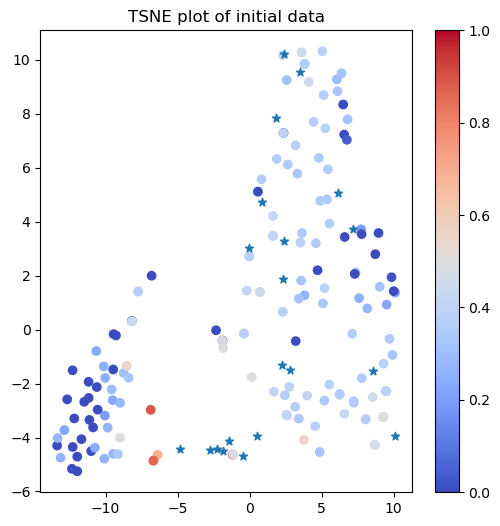

In [44]:
fig, ax = plt.subplots(figsize = (6,6))

sc = ax.scatter(x_tsne_og[:,0][:len(x_data_norm)], x_tsne_og[:,1][:len(x_data_norm)], c = train_y, cmap = plt.cm.coolwarm)
ax.scatter(x_tsne_og[:,0][len(x_data_norm):], x_tsne_og[:,1][len(x_data_norm):], marker='*')
ax.set_title("TSNE plot of initial data")
fig.colorbar(sc, ax = ax)

## Prep new sample table for next experiment

In [45]:
x_fractions = unnormalize(candidates, bounds_torch_norm)

In [46]:
target_volume = 1700
target_dilution = 0.1 # mol Si/L saxs sample
constants_fp = './constants_2024_11_14.json'
samples_write_fp = 'Sample_table_2024_11_14_optimizationRound3.csv'


In [47]:
samples_gen = []
for row in x_fractions:
    teos_vf = float(row[0])
    ammonia_vf = float(row[1])
    water_vf = float(row[2])

    sample = samples.SolidSilicaSample(target_volume, teos_vol_frac = teos_vf, ammonia_vol_frac=ammonia_vf, water_vol_frac=water_vf, reactant_fp = constants_fp)
    sample.calculate_reactant_volumes()
    sample.calculate_dilution_volumefraction(target_dilution)
    sample.calculate_silica_mass_concentration()
    sample.calculate_silica_mass_fraction()
    samples_gen.append(sample)

In [48]:
synth_table = samples.generate_synthesis_table(samples_gen)

In [49]:
synth_table['ethanol_dilute_vol'] = np.round(target_volume*(1-synth_table['dilution_volume_fraction']))
synth_table['sample_dilute_vol'] = np.round(target_volume * synth_table['dilution_volume_fraction'])

In [50]:
synth_table.loc[synth_table['ethanol_dilute_vol'] < 0, 'ethanol_dilute_vol'] = 0
synth_table.loc[synth_table['sample_dilute_vol'] > target_volume, 'sample_dilute_vol'] = target_volume

In [51]:
#assign rows to sample table
rows = ['A', 'B', 'C', 'D', 'E', 'F']
cols = [1, 2, 3, 4, 5, 6, 7, 8]

wells = []

#skip [B,E]x[2,7]
for row in rows:
    for col in cols:
        if row in ['B', 'E'] and col in [2, 7]:
            pass
        else:
            wells.append(row + str(col))

In [52]:
synth_table['well'] = wells[:len(synth_table)]


In [53]:
synth_table['dilute_well'] = wells[len(synth_table):2*len(synth_table)]

## Visualize new batch

In [54]:
synth_data['rank'] = synth_data['ap_distance'].rank()

In [55]:
best_row = synth_data.iloc[synth_data['ap_distance'].argmin()]

In [56]:
best10 = synth_data.iloc[synth_data['rank'].argsort().iloc[:10]]

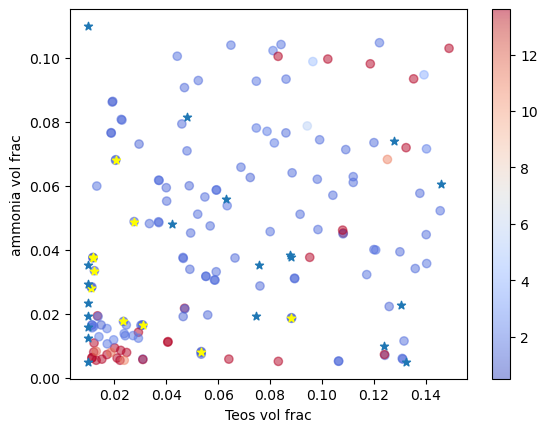

In [57]:
fig, ax = plt.subplots()

sc = ax.scatter(synth_data['teos_vol_frac'], synth_data['ammonia_vol_frac'], c = synth_data['ap_distance'], cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac')
ax.set_ylabel('ammonia vol frac')


ax.scatter(best10['teos_vol_frac'], best10['ammonia_vol_frac'], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

ax.scatter(synth_table['teos_volume']/1700, synth_table['ammonia_volume']/target_volume, marker = '*')

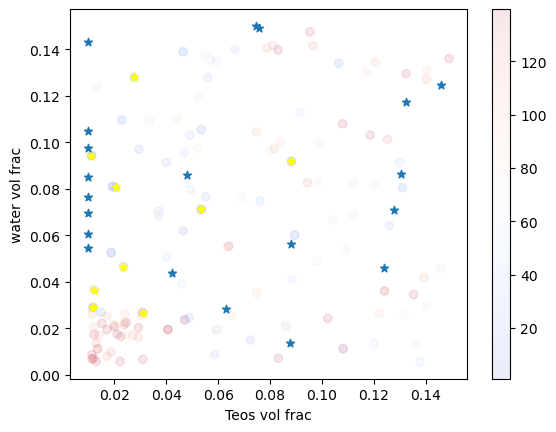

In [58]:
fig, ax = plt.subplots()

sc = ax.scatter(synth_data['teos_vol_frac'], synth_data['water_vol_frac'], c = synth_data['rank'], cmap = plt.cm.coolwarm, alpha=0.1)
ax.set_xlabel('Teos vol frac')
ax.set_ylabel('water vol frac')
cbar = fig.colorbar(sc, ax = ax)

ax.scatter(best10['teos_vol_frac'], best10['water_vol_frac'], marker = '*', color = 'yellow')

ax.scatter(synth_table['teos_volume']/1700, synth_table['water_volume']/target_volume, marker = '*')

In [59]:
synth_table

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,ethanol_dilute_vol,sample_dilute_vol,well,dilute_well
0,97eb1065-a266-4bf0-8d3d-70c6c45e135d,17.000000,59.886661,177.900108,1445.213231,2.232143,2.691584,0.003296,0.0,1700.0,A1,C7
1,e7968010-0689-42a7-8797-2a3e9b7ae66c,128.723552,59.976938,253.625649,1257.673861,0.294790,20.380603,0.024399,1199.0,501.0,A2,C8
2,fd6bad8e-aedb-430a-a5bd-e667c317cbb5,17.000000,8.500000,243.605258,1430.894743,2.232143,2.691584,0.003277,0.0,1700.0,A3,D1
3,9d522d04-006c-4226-847e-27f987ea389d,217.168911,125.968067,120.627048,1236.235975,0.174732,34.384022,0.041389,1403.0,297.0,A4,D2
4,9f62f2c7-89e5-4122-8d6c-f876026d5975,72.110605,81.826747,74.426442,1471.636206,0.526225,11.417162,0.014097,805.0,895.0,A5,D3
5,46a44e80-dbc4-4e33-906e-dcfc99b242f2,248.195589,102.837770,211.959846,1137.006795,0.152889,39.296428,0.046609,1440.0,260.0,A6,D4
6,23754685-93a7-40a9-aefd-34d561daf1a9,149.006813,65.518953,22.988700,1462.485534,0.254662,23.592021,0.029162,1267.0,433.0,A7,D5
7,c8a04429-83dd-4779-a587-8e58a018413f,225.206037,8.500000,199.486357,1266.807606,0.168496,35.656527,0.042781,1414.0,286.0,A8,D6
8,326de561-5b2e-46d0-a192-b9bff6174040,17.000000,186.999999,102.630764,1393.369238,2.232143,2.691584,0.003300,0.0,1700.0,B1,D7
9,ee49095a-c041-4633-b695-6863ffcee3fa,81.911343,138.443228,146.033549,1333.611880,0.463262,12.968898,0.015754,912.0,788.0,B3,D8


In [60]:
synth_table.to_csv('SampleTable_2024_11_14_OptimizationRound3.csv')